In [1]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
import scipy
import json
import pickle

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

import tuner_library
import utilities as util
import matplotlib.pyplot as plt

In [2]:

import scipy
from lime.lime_text import LimeTextExplainer
#dictionary [key, explanation]

class tuner:
    def __init__(self, text, filename, class_names):
        self.dict = {}
        self.sigmas = []
        self.text = text
        self.filename = filename
        self.class_names = class_names
    
    def initialize():
        self.dict.clear()
        return
    
    #get the blackbox prediction for a text instance using filename(model.pkl file) 
    def get_Prediction(self):
        print("HII")
        loaded_model = pickle.load(open(self.filename, 'rb'))
        result = loaded_model.predict_proba([self.text])
        return json.dumps(result.tolist())
    
    #get the explanations or fill up all the explanantion field for a particular sigma in dictionary with key value as sigma
    def get_Explanation(self, sigma):
        if sigma in self.dict:
            print("YES")
            return self.dict[sigma]
        else:
            explainer = LimeTextExplainer(kernel_width=sigma,class_names=self.class_names)
            print("sigma = " + str(sigma))
            black_box = pickle.load(open(self.filename, 'rb'))
            exp = explainer.explain_instance(self.text, black_box.predict_proba, num_features=6)
            self.dict[sigma] = exp
            return self.dict[sigma]
        return 
    
    #to plot the entropy v/s sigma curve, this fuction calulates the value of entropy for all the sigmas and then return sigmas, entropies
    def get_Sigma_Entropy(self):
        sigmas = []
        entropies = []
        for key in sorted (self.dict.keys()):
            weight_per_bucket = []
            for b in range(11):
                weight_per_bucket.append(0)
            exp = self.dict[key]
            list_pair = [(p1, p2) for idx1, p1 in enumerate(exp.weights) for idx2, p2 in enumerate(exp.bb_labels) if idx1==idx2]
            list_pair.sort()
            for t in list_pair:
                if(t[1] >= 0 and t[1] < 0.1):
                    weight_per_bucket[0] += t[0]
                elif(t[1] >= 0.1 and t[1] < 0.2):
                    weight_per_bucket[1] += t[0]
                elif(t[1] >= 0.2 and t[1] < 0.3):
                    weight_per_bucket[2] += t[0]
                elif(t[1] >= 0.3 and t[1] < 0.4):
                    weight_per_bucket[3] += t[0]
                elif(t[1] >= 0.4 and t[1] < 0.5):
                    weight_per_bucket[4] += t[0]
                elif(t[1] >= 0.5 and t[1] < 0.6):
                    weight_per_bucket[5] += t[0]
                elif(t[1] >= 0.6 and t[1] < 0.7):
                    weight_per_bucket[6] += t[0]
                elif(t[1] >= 0.7 and t[1] < 0.8):
                    weight_per_bucket[7] += t[0]
                elif(t[1] >= 0.8 and t[1] < 0.9):
                    weight_per_bucket[8] += t[0]
                elif(t[1] >= 0.9 and t[1] < 1.0):
                    weight_per_bucket[9] += t[0]
                else :
                    weight_per_bucket[10] += t[0]
            norm_weight_per_bucket = [float(i)/sum(weight_per_bucket) for i in weight_per_bucket]
            entropy = scipy.stats.entropy(norm_weight_per_bucket)
            self.dict[key].entropy = entropy
            sigmas.append(key)
            entropies.append(entropy)
        return sigmas, entropies
      
    #to be called only after the get_Explanation for sigma is called
    #used to plot the weight distribution plot of neighbourhood points (vary for each sigma)
    def get_Weight_Distribution_Plot_Per_Sigma(self, sigma):
        return self.dict[sigma].weights, self.dict[sigma].bb_labels
    
    #to be called only after the get_Explanation for sigma is called
    #returns all the 4 models' rmse (constant model, linear model(used by LIME), decision tree, random forests)    
    def get_RMSEs_And_Sigmas(self):
        constant_rmse = []
        linear_rmse = []
        decisionTree_rmse = []
        randomForest_rmse = []
        sigmas = []
        for key in sorted (self.dict.keys()):
            sigmas.append(key)
            constant_rmse.append(self.dict[key].naive_score)
            linear_rmse.append(self.dict[key].score)
            decisionTree_rmse.append(self.dict[key].rf_score)
            randomForest_rmse.append(self.dict[key].rf_2_score)
        return sigmas, constant_rmse, linear_rmse, decisionTree_rmse, randomForest_rmse
    
    def getRange_Constant_Model(self):
        sigmas,constant_rmse, linear_rmse, decisionTree_rmse, randomForest_rmse = self.get_RMSEs_And_Sigmas()
        const_range = []
        const_range.append(0.39)
        for i in range(len(sigmas)):
            if(linear_rmse[i] < constant_rmse[i]):
                const_range.append(sigmas[i])
                return const_range
        const_range.append(0.39)
        return const_range
    
    def getRange_Linear_Model(self):
        sigmas,constant_rmse, linear_rmse, decisionTree_rmse, randomForest_rmse = self.get_RMSEs_And_Sigmas()
        const_range = self.getRange_Constant_Model()
        linear_range = []
        linear_range.append(const_range[1])
        diff = [m - n for m,n in zip(linear_rmse,randomForest_rmse)]
        for i in range(len(sigmas)):
            if(diff[len(sigmas)-i-1] < 0):
                linear_range.append(sigmas[len(sigmas)-i-1])
                return linear_range
        linear_range.append(const_range[1])
        return linear_range
        
            

In [3]:
class_names = ['negative',  'positive']
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [4]:
batch_1 = df[:2000]

In [5]:

# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [6]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [7]:

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])


In [8]:
np.array(padded).shape


(2000, 59)

In [9]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 59)

In [10]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    input_ids = input_ids.type(torch.LongTensor)
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [11]:
features = last_hidden_states[0][:,0,:].numpy()
labels = batch_1[1]


In [12]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [13]:
from sklearn.linear_model import LogisticRegression

class Bert_LR(LogisticRegression):
    def __init__(self, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer

    def predict(self, X):
        X = pd.Series(X)
        tokenized = X.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
        max_len = 0
        for i in tokenized.values:
            if len(i) > max_len:
                max_len = len(i)

        padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

        attention_mask = np.where(padded != 0, 1, 0)
        input_ids = torch.tensor(padded)  
        attention_mask = torch.tensor(attention_mask)

        with torch.no_grad():
            input_ids = input_ids.type(torch.LongTensor)
            last_hidden_states = model(input_ids, attention_mask=attention_mask)

        features = last_hidden_states[0][:,0,:].numpy() 
        scores = self.decision_function(features)
        if len(scores.shape) == 1:
            indices = (scores > 0).astype(np.int)
        else:
            indices = scores.argmax(axis=1)
        return self.classes_[indices]

    def predict_proba(self, X):
        ovr = (self.multi_class in ["ovr", "warn"] or
               (self.multi_class == 'auto' and (self.classes_.size <= 2 or
                                                self.solver == 'liblinear')))
        X = pd.Series(X)
        tokenized = X.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
        max_len = 0
        for i in tokenized.values:
            if len(i) > max_len:
                max_len = len(i)

        padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

        attention_mask = np.where(padded != 0, 1, 0)
        input_ids = torch.tensor(padded)  
        attention_mask = torch.tensor(attention_mask)

        with torch.no_grad():
            input_ids = input_ids.type(torch.LongTensor)
            last_hidden_states = model(input_ids, attention_mask=attention_mask)

        features = last_hidden_states[0][:,0,:].numpy()

        if ovr:
            return super()._predict_proba_lr(features)
        else:
            decision = self.decision_function(features)
            if decision.ndim == 1:
                # Workaround for multi_class="multinomial" and binary outcomes
                # which requires softmax prediction with only a 1D decision.
                decision_2d = np.c_[-decision, decision]
            else:
                decision_2d = decision
            return softmax(decision_2d, copy=False)


In [14]:
lr_clf = Bert_LR(tokenizer)
lr_clf.fit(train_features, train_labels)

Bert_LR(tokenizer=<transformers.tokenization_distilbert.DistilBertTokenizer object at 0x0000021D6222C2B0>)

In [15]:
lr_clf.predict_proba(batch_1[0])

array([[0.06180827, 0.93819173],
       [0.99843737, 0.00156263],
       [0.95223111, 0.04776889],
       ...,
       [0.57828493, 0.42171507],
       [0.77104011, 0.22895989],
       [0.76766508, 0.23233492]])

In [16]:
pickle.dump(lr_clf, open("distilBert_model.pkl", 'wb'))

In [18]:
text = batch_1[0][2]
text

"they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes"

In [19]:
from tuner_library import tuner
tl = tuner(text,'distilBert_model.pkl', class_names)
result = util.JsonToArray(tl.get_Prediction()) 
result

HII


array([[0.95223123, 0.04776877]])

In [20]:
sigma = 25
#get the explanation for a particular sigma (all the explanation fields are filled)
exp = tl.get_Explanation(sigma)
print(exp.rf_score)
exp.save_to_file('explanation_25.html')

sigma = 25
0.020202280106177663


In [21]:
k = 0.39062499968
tl.sigmas = k*2**np.arange(13)

In [22]:
for sigma in tl.sigmas:
    exp = tl.get_Explanation(sigma) 

sigma = 0.39062499968
sigma = 0.78124999936
sigma = 1.56249999872
sigma = 3.12499999744
sigma = 6.24999999488
sigma = 12.49999998976
sigma = 24.99999997952
sigma = 49.99999995904
sigma = 99.99999991808
sigma = 199.99999983616
sigma = 399.99999967232
sigma = 799.99999934464
sigma = 1599.99999868928


In [23]:
#for plotting entropy v/s sigma curve
sigmas, entropies = tl.get_Sigma_Entropy()
#get the rmse values(all the explanation models) for all the sigmas 
sigmas,constant_rmse, linear_rmse, decisionTree_rmse, randomForest_rmse = tl.get_RMSEs_And_Sigmas()

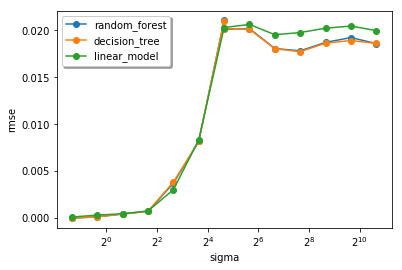

In [24]:
#plot the sigma v/s rmses 
axes=plt.gca()

plt.xscale('log', basex = 2)
plt.xlabel("sigma")
plt.ylabel("rmse");

plt.plot(sigmas, randomForest_rmse,'-o',label = 'random_forest')
plt.plot(sigmas, decisionTree_rmse,'-o',label = 'decision_tree')
plt.plot(sigmas, linear_rmse,'-o', label = 'linear_model')
# plt.plot(width, constant_rmse,'-o',label = 'constant_model')
# plt.suptitle('Example id = ' + str(idx))

legend = plt.legend(loc='upper left', shadow=True)

legend.get_frame()

#plot the sigma v/s rmses 
# axes=plt.gca()

# plt.xscale('log', basex = 2)
# plt.xlabel("sigma")
# plt.ylabel("rmse");

# plt.plot(sigmas[0:4], randomForest_rmse[0:4],'-o',label = 'random_forest')
# plt.plot(sigmas[0:4], decisionTree_rmse[0:4],'-o',label = 'decision_tree')
# plt.plot(sigmas[0:4], linear_rmse[0:4],'-o', label = 'linear_model')
# plt.plot(sigmas[0:4], constant_rmse[0:4],'-o',label = 'constant_model')
# # plt.suptitle('Example id = ' + str(idx))

# legend = plt.legend(loc='upper left', shadow=True)

# legend.get_frame()

1


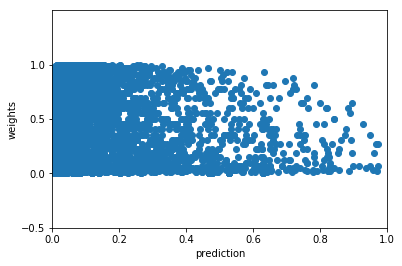

In [30]:
 #for plotting weight distribution of neighbourhood points for a particular sigma
weights, predictions = tl.get_Weight_Distribution_Plot_Per_Sigma(25)
sigma = 1
#plot the weight distribution of neighbour points for a particular sigma
axes=plt.gca()
plt.ylabel("weights")
plt.xlabel("prediction");
plt.ylim(-0.5, 1.5)
major_ticks = np.arange(-0.5, 1.5, 0.5)
axes.set_yticks(major_ticks) 
plt.xlim(0,1)
print(sigma)
plt.plot(predictions, weights,'o')